In [ ]:
! pip install langchain_core langchain_openai langgraph

In [9]:
import os, getpass
def set_env(key: str,env_var_name: str):
    os.environ[env_var_name] = key

api_key = getpass.getpass("Enter your OpenAI API Key: ")
set_env(api_key, "OPENAI_API_KEY")

In [10]:
#configuring llm
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model='gpt-4o-2024-08-06', api_key=api_key)

In [20]:
#aumenting LLM : preparing the llm in the way it will be used. (example - fine tuning, structured output , system prompt etc)
#example: I need to have structured output , i will augment the llm to return structured output
from pydantic import BaseModel,Field
class search_input(BaseModel):
    query: str = Field(None,title="mathematical expression that will be used to search for the answer")
    justification: str = Field(None,title="justification for the answer")
    
structured_llm=model.with_structured_output(search_input)

output = structured_llm.invoke("what is the value of 2 added with 5 then the result is multiplied by 3")
print(output)
print(output.query)
print(output.justification)

query='(2 + 5) * 3' justification="To find the value of the given expression, we first perform the addition inside the parentheses and then multiply the result by 3.\\n\\nLet's break down the computation step-by-step:\\n1. **Addition Step:**\\n   - Add the numbers inside the parentheses (2 + 5):\\n   - 2 + 5 = 7\\n\\n2. **Multiplication Step:**\\n   - Multiply the result from the addition by 3:\\n   - 7 * 3 = 21\\n\\nTherefore, the final result of the expression is 21."
(2 + 5) * 3
To find the value of the given expression, we first perform the addition inside the parentheses and then multiply the result by 3.\n\nLet's break down the computation step-by-step:\n1. **Addition Step:**\n   - Add the numbers inside the parentheses (2 + 5):\n   - 2 + 5 = 7\n\n2. **Multiplication Step:**\n   - Multiply the result from the addition by 3:\n   - 7 * 3 = 21\n\nTherefore, the final result of the expression is 21.


In [25]:
def addition(a:int,b:int):
    return a+b

def multiplication(a:int,b:int):
    return a*b

def divide(a:int,b:int):
    return a/b

def subtraction(a:int,b:int):
    return a-b

def power(a:int,b:int):
    return a**b

llm_with_tools=model.bind_tools([addition,multiplication,divide,subtraction,power])

# testing 
output = llm_with_tools.invoke("what is the value of 2 added with 5 then the result is multiplied by 3")
# print(output)
print(output.tool_calls)

[{'name': 'addition', 'args': {'a': 2, 'b': 5}, 'id': 'call_pxLQeVi8K7kiBXLywWOjnZDP', 'type': 'tool_call'}, {'name': 'multiplication', 'args': {'a': 7, 'b': 3}, 'id': 'call_s6osIJH2Lfzsg3RbcKgp2jyZ', 'type': 'tool_call'}]


In [11]:
# jokes example 
# step 1 - defining graph state
from typing_extensions import TypedDict

class graph_state(TypedDict):
    topic : str
    joke : str
    improved_joke : str
    final_joke : str

In [13]:
# step -2 building the graph elements
#nodes
def generate_joke(state:graph_state):
    msg=model.invoke(f"tell me a joke about {state['topic']}")
    return {'joke':msg.content}

def improve_joke(state:graph_state):
    msg=model.invoke(f"improve the joke {state['joke']}")
    return {'improved_joke':msg.content}

def finalize_joke(state:graph_state):
    msg=model.invoke(f"finalize the joke {state['improved_joke']}")
    return {'final_joke':msg.content}

#coditional_node
def check_punchline(state:graph_state):
    # 'this is called a conditional node / gate'
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    else:
        return "Fail"

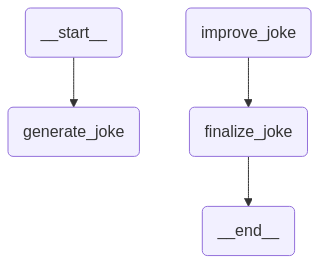

In [14]:
# Step 3 - Building the workflow using langgraph
from langgraph.graph import StateGraph,START,END 
from IPython.display import Image,display

workflow = StateGraph(graph_state)
workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("finalize_joke",finalize_joke)

workflow.add_edge(START,"generate_joke")
# workflow.add_conditional_edge("generate_joke",check_punchline,{"Pass":"improve_joke","Fail":END})
workflow.add_edge("improve_joke","finalize_joke")
workflow.add_edge("finalize_joke",END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [15]:
# step 4 - executing the workflow
state=chain.invoke({"topic":"elephant"})
print("initial joke",state['joke'])
if 'improved_joke' in state:
    print("improved joke",state['improved_joke'])
    print("final joke",state['final_joke'])
else : 
    print("Failed at conditional node")
 

initial joke Sure, here's a joke about an elephant:

Why don’t elephants use computers?

Because they’re afraid of the mouse!
Failed at conditional node


In [16]:
# parallel execution in langgraph
# when you have multiperspective for one task , multi query RAG

class state(TypedDict):
    topic:str
    joke:str
    peom:str
    story:str
    combined:str

# three parallel calls and then aggregate the results
def generate_joke(state:state):
    msg=model.invoke(f"tell me a joke about {state['topic']}")
    return {'joke':msg.content}

def generate_peom(state:state):
    msg=model.invoke(f"tell me a peom about {state['topic']}")
    return {'peom':msg.content}

def generate_story(state:state):
    msg=model.invoke(f"tell me a story about {state['topic']}")
    return {'story':msg.content}

def combine_results(state:state):
    combined = state['joke'] + state['peom'] + state['story']
    return {'combined':combined}


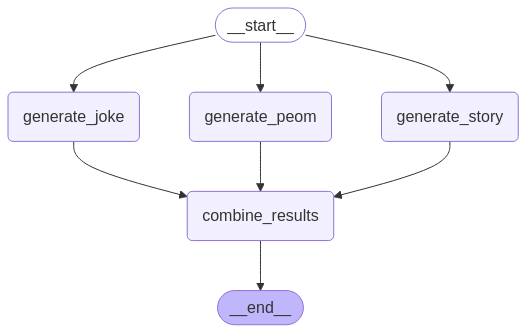

In [18]:
parrallel_workflow = StateGraph(state)
parrallel_workflow.add_node("generate_joke",generate_joke)
parrallel_workflow.add_node("generate_peom",generate_peom)
parrallel_workflow.add_node("generate_story",generate_story)
parrallel_workflow.add_node("combine_results",combine_results)

parrallel_workflow.add_edge(START,"generate_joke")
parrallel_workflow.add_edge(START,"generate_peom")
parrallel_workflow.add_edge(START,"generate_story")

parrallel_workflow.add_edge("generate_joke","combine_results")
parrallel_workflow.add_edge("generate_peom","combine_results")
parrallel_workflow.add_edge("generate_story","combine_results")

parrallel_workflow.add_edge("combine_results",END)

parrallel_chain = parrallel_workflow.compile()

display(Image(parrallel_chain.get_graph().draw_mermaid_png()))

In [19]:
state=parrallel_chain.invoke({"topic":"elephant"})
print("combined",state['combined'])


combined Sure! Here's one for you:

Why don't elephants use computers?

Because they're afraid of the mouse!In the lush, green cradle where the sun softly beams,  
Roams the gentle giant of our dreams.  
With a hide of gray and wisdom in its eyes,  
The mighty elephant treads beneath vast skies.  

Ears like sails unfurled catch whispers of the breeze,  
A symphony of savannahs, rustling leaves on trees.  
Trunk sways like a pendulum, fluid and alive,  
In this ancient dance, it's evolution's archive.  

Tusks as white as ivory, arches of the earth,  
Carved by time and history, symbols of their worth.  
They tell tales of ages, of lands trekked and seen,  
Of waterholes discovered in lands lush and lean.  

Oh, architects of passage, gentle titans roam,  
They carve through the wilderness, their kitchen, their home.  
Their footsteps echo thunder, a rhythmic, slow parade,  
In the quiet of the night, their majesty displayed.  

Matriarchs lead with patience, wisdom running deep,  
Gui

In [ ]:
#routing in langgraph
